In [1]:
%pip uninstall -y hipscat hipscat-import hats hats-import lsdb
%pip install git+https://github.com/astronomy-commons/hats
%pip install git+https://github.com/astronomy-commons/lsdb
%pip install git+https://github.com/astronomy-commons/hats-import

Found existing installation: hats 0.4.2.dev6+g1628457
Uninstalling hats-0.4.2.dev6+g1628457:
  Successfully uninstalled hats-0.4.2.dev6+g1628457
Found existing installation: hats-import 0.4.0
Uninstalling hats-import-0.4.0:
  Successfully uninstalled hats-import-0.4.0
Found existing installation: lsdb 0.4.1.dev8+gf32d7b0
Uninstalling lsdb-0.4.1.dev8+gf32d7b0:
  Successfully uninstalled lsdb-0.4.1.dev8+gf32d7b0
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/astronomy-commons/hats to /tmp/pip-req-build-574t4l0q
  Running command git clone --quiet https://github.com/astronomy-commons/hats /tmp/pip-req-build-574t4l0q
  Resolved https://github.com/astronomy-commons/hats to commit 16284570a8fb4197342383e63b442d3389e1f10f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hats: filename=hats-0.4.2.dev6+g1628457-py3-none-any.whl size=71914 sha2

In [4]:
import lsdb
from lsdb.core.search import ConeSearch
from dask.distributed import Client

In [24]:
racs = lsdb.read_hats(
    'hats/racs-mid-dr2',
    columns=['RA', 'Dec', 'Peak_flux',],
)
gaia = lsdb.read_hats(
    'https://data.lsdb.io/hats/gaia/gaia/',
    margin_cache='https://data.lsdb.io/hats/gaia/gaia_10arcs/',
    columns=['ra', 'dec', 'source_id', 'parallax_over_error'],
    search_filter=ConeSearch(ra=45.0, dec=-45, radius_arcsec=20 * 3600),
)
gaia_distances = lsdb.read_hats(
    'https://data.lsdb.io/hats/gaia/gaia_edr3_distances/',
    margin_cache='https://data.lsdb.io/hats/gaia/gaia_edr3_distances_10arcs/',
)

catalog = racs.crossmatch(
    gaia,
    radius_arcsec=6,
    suffixes=('', '_gaia'),
).join(
    gaia_distances,
    left_on='source_id_gaia',
    right_on='source_id',
    suffixes=('', '_gaia_dist'),
).query(
    'parallax_over_error_gaia > 10.0 and '
)
catalog

,RA,Dec,Peak_flux,ra_gaia,dec_gaia,source_id_gaia,parallax_over_error_gaia,_dist_arcsec,source_id_gaia_dist,r_med_geo_gaia_dist,r_lo_geo_gaia_dist,r_hi_geo_gaia_dist,r_med_photogeo_gaia_dist,r_lo_photogeo_gaia_dist,r_hi_photogeo_gaia_dist,flag_gaia_dist,ra_gaia_dist,dec_gaia_dist,Norder_gaia_dist,Dir_gaia_dist,Npix_gaia_dist
npartitions=17,,,,,,,,,,,,,,,,,,,,,
2332864606977916928,double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],int8[pyarrow],int64[pyarrow],int64[pyarrow]
2337368206605287424,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2558044588346441728,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2576058986855923712,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [25]:
%%time
with Client(n_workers=10, memory_limit='10GB') as client:
    df = catalog.compute()
df

/astro/users/kmalanch/.virtualenvs/tape/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44363 instead
  warnings.warn(
/astro/users/kmalanch/.virtualenvs/tape/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 13.12 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 8.7 s, sys: 4.97 s, total: 13.7 s
Wall time: 29.2 s


,RA,Dec,Peak_flux,ra_gaia,dec_gaia,source_id_gaia,parallax_over_error_gaia,_dist_arcsec,source_id_gaia_dist,r_med_geo_gaia_dist,...,r_hi_geo_gaia_dist,r_med_photogeo_gaia_dist,r_lo_photogeo_gaia_dist,r_hi_photogeo_gaia_dist,flag_gaia_dist,ra_gaia_dist,dec_gaia_dist,Norder_gaia_dist,Dir_gaia_dist,Npix_gaia_dist
_healpix_29,,,,,,,,,,,,,,,,,,,,,
2336087816527204966,51.628659,-64.628173,1.119895,51.627558,-64.628589,4672175620566163712,10.230495,2.264136,4672175620566163712,2708.89941,...,2936.02734,2656.33032,2464.71216,2864.03809,10033,51.627558,-64.628589,3,0.0,518.0
2336173444409046665,50.524059,-64.746514,15.030953,50.522027,-64.745251,4672347075660449792,15.268177,5.514956,4672347075660449792,761.477051,...,808.756042,736.056946,698.365601,777.288391,10033,50.522027,-64.745251,3,0.0,518.0
2336173536175217627,50.522525,-64.745512,4.59378,50.522027,-64.745251,4672347075660449792,15.268177,1.209902,4672347075660449792,761.477051,...,808.756042,736.056946,698.365601,777.288391,10033,50.522027,-64.745251,3,0.0,518.0
2336507810034551333,55.440881,-63.989185,8.079965,55.439026,-63.989545,4673015613090460672,25.910046,3.202675,4673015613090460672,673.112061,...,697.596619,675.939026,654.561462,701.550659,10033,55.439026,-63.989545,3,0.0,518.0
2336721460783205130,56.115226,-63.142637,1.230149,56.112971,-63.14223,4673442910796881152,14.400324,3.950223,4673442910796881152,1377.57019,...,1481.40723,1366.92358,1305.51599,1436.4939,10033,56.112971,-63.14223,3,0.0,518.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540791018764569909,54.132086,-26.971569,1.916067,54.130536,-26.971397,5081582035047779456,11.684999,5.013882,5081582035047779456,501.752563,...,548.448853,474.90863,439.088989,507.085571,10033,54.130536,-26.971397,2,0.0,141.0
2540795444396051010,54.308388,-26.786435,1.348403,54.309787,-26.786636,5081590869797716864,17.465971,4.553051,5081590869797716864,495.721893,...,525.267822,504.364166,476.520203,534.627686,10033,54.309787,-26.786636,2,0.0,141.0
2558173801096453997,34.681172,-28.317921,28.214376,34.682627,-28.317355,5116347600580942592,51.15387,5.041455,5116347600580942592,559.135376,...,568.983215,559.978699,549.740601,570.89563,10033,34.682627,-28.317355,2,0.0,142.0


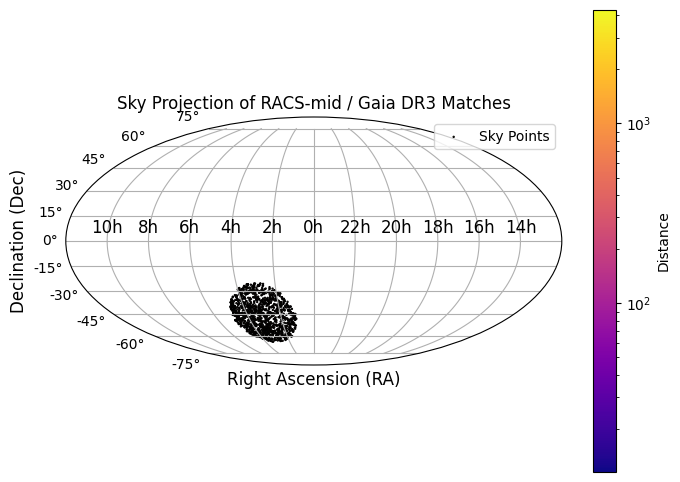

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from matplotlib.colors import LogNorm

def plot_sky_projection(ra, dec, distance, projection='mollweide'):
    sky_coords = SkyCoord(ra=ra * u.degree, dec=dec * u.degree, frame='icrs')

    ra_rad = sky_coords.ra.wrap_at(180 * u.degree).radian
    dec_rad = sky_coords.dec.radian

    plt.figure(figsize=(8, 6))
    ax = plt.subplot(111, projection=projection)
    sc = ax.scatter(-ra_rad, dec_rad, c=distance, cmap='plasma', s=0.5, edgecolor='black', label='Sky Points',
                   norm=LogNorm())

    ax.set_xticklabels(['14h', '16h', '18h', '20h', '22h', '0h', '2h', '4h', '6h', '8h', '10h'][::-1], fontsize=12)
    ax.set_xlabel('Right Ascension (RA)', fontsize=12)
    ax.set_ylabel('Declination (Dec)', fontsize=12)
    ax.grid(True)
    ax.set_title('Sky Projection of RACS-mid / Gaia DR3 Matches')

    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', label='Distance')
    plt.legend()
    plt.show()

plot_sky_projection(df["RA"].to_numpy(), df["Dec"].to_numpy(), df["r_med_geo_gaia_dist"].to_numpy())